In [ ]:
# ID: 2018115809 (undergraduate)
# NAME: Dohun Kim
# File name: model.ipynb
# Platform: Python 3.9.5 on Ubuntu Linux 18.04
# Required Package(s): numpy=1.20.3, pandas=1.2.4 matplotlib=3.4.2

# Multi-Label Classification with MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from anime_classification import MultiLabelClassifier, Adam, Trainer

## Load Vectorized Synopsis/Genre Data

In [2]:
synop_vec = pd.read_csv('synopsis_vector.csv')
synop_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1,-0.115479,-3.919922,0.511230,1.325195,2.685547,1.791992,-1.767578,-1.251953,-1.898438,...,0.862305,-0.740234,-1.121094,-0.729004,1.063477,1.272461,-0.246826,1.380859,1.921875,2.216797
1,5,2.314453,-2.361328,-0.012909,2.703125,1.200195,3.173828,-1.356445,-2.605469,-1.958984,...,0.493652,-0.944824,-0.937500,-0.261475,2.087891,1.500000,-0.221802,0.646973,2.218750,0.958496
2,6,-0.226196,-2.597656,-0.182983,2.042969,1.670898,1.951172,-1.367188,-2.917969,-0.160767,...,-1.435547,-1.021484,-2.537109,-2.455078,2.013672,1.943359,0.622559,1.703125,2.357422,1.232422
3,7,0.844238,-0.527344,0.271973,0.752930,1.575195,2.492188,-1.652344,-2.705078,-2.269531,...,-0.367920,-1.791992,-1.804688,-2.474609,2.878906,0.425537,-0.583008,3.107422,0.836426,1.042969
4,8,1.521484,-2.650391,0.424072,1.816406,2.029297,1.694336,0.607910,-1.333984,-1.023438,...,1.650391,-1.703125,-2.476562,-4.492188,1.403320,0.638672,0.058594,1.249023,2.457031,2.517578


In [3]:
genre_vec = pd.read_csv('genre.csv')
genre_vec.head()

,MAL_ID,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,1,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,5,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Split Train-Test Set

In [4]:
synop_cols = synop_vec.columns.drop('MAL_ID').values
genre_cols = genre_vec.columns.drop('MAL_ID').values

In [5]:
full_vec = pd.merge(synop_vec, genre_vec)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,-0.115479,-3.919922,0.511230,1.325195,2.685547,1.791992,-1.767578,-1.251953,-1.898438,...,0,0,1,0,0,0,0,0,0,0
1,5,2.314453,-2.361328,-0.012909,2.703125,1.200195,3.173828,-1.356445,-2.605469,-1.958984,...,0,0,1,0,0,0,0,0,0,0
2,6,-0.226196,-2.597656,-0.182983,2.042969,1.670898,1.951172,-1.367188,-2.917969,-0.160767,...,0,0,0,0,0,0,0,0,0,0
3,7,0.844238,-0.527344,0.271973,0.752930,1.575195,2.492188,-1.652344,-2.705078,-2.269531,...,0,0,0,0,0,1,0,0,0,0
4,8,1.521484,-2.650391,0.424072,1.816406,2.029297,1.694336,0.607910,-1.333984,-1.023438,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# random shuffle and re-index
full_vec = full_vec.sample(frac=1).reset_index(drop=True)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,37188,-1.237305,-2.369141,0.256836,0.166260,1.199219,3.632812,1.019531,-1.023438,-0.323730,...,0,1,0,0,0,0,0,0,0,0
1,21603,1.604492,-2.251953,-0.002232,1.946289,1.418945,2.054688,-0.674805,-1.374023,-1.764648,...,0,0,0,0,1,1,0,0,0,0
2,34152,0.204590,-1.486328,0.879395,0.829102,0.057281,1.226562,-0.578613,-1.309570,-1.560547,...,0,0,0,0,0,0,0,0,0,0
3,15,0.627930,-0.849121,-0.200317,2.763672,0.887695,3.500000,-1.040039,-2.257812,-2.451172,...,0,0,0,1,0,0,0,0,0,0
4,34052,0.231812,-1.928711,0.923828,1.302734,0.923828,5.023438,-1.857422,-0.906250,-3.646484,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# split dataframe to train-test numpy array
train_ratio = 0.95
num_train = int(len(full_vec) * train_ratio)

x_train = full_vec[synop_cols][:num_train].values
t_train = full_vec[genre_cols][:num_train].values
id_train = full_vec['MAL_ID'][num_train:].values

x_test = full_vec[synop_cols][num_train:].values
t_test = full_vec[genre_cols][num_train:].values
id_test = full_vec['MAL_ID'][num_train:].values

del synop_vec, genre_vec, full_vec

In [8]:
# standardization
x_train_mean = x_train.mean(axis=0)
x_train_std  = x_train.std(axis=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test  = (x_test  - x_train_mean) / x_train_std

## Define Model

In [9]:
input_size  = len(synop_cols)
output_size = len(genre_cols)

model = MultiLabelClassifier(input_size=input_size,
                             hidden_size_list=[50, 50],
                             output_size=output_size,
                             use_dropout=True,
                             dropout_ratio=0.5,
                             use_batchnorm=True)
                            #  use_focal_loss=True,
                            #  focal_gamma=6)
model.summary()

------------------------------------------------------------
Affine(input_size=100, output_size=50, weight_init=he)
------------------------------------------------------------
BatchNormalization(size_layer=50)
------------------------------------------------------------
Relu()
------------------------------------------------------------
Dropout(dropout_ratio=0.5)
------------------------------------------------------------
Affine(input_size=50, output_size=50, weight_init=he)
------------------------------------------------------------
BatchNormalization(size_layer=50)
------------------------------------------------------------
Relu()
------------------------------------------------------------
Dropout(dropout_ratio=0.5)
------------------------------------------------------------
Affine(input_size=50, output_size=43, weight_init=xavier)
------------------------------------------------------------
CrossEntropyLoss()
------------------------------------------------------------


In [10]:
optimizer = Adam(lr=0.001)
trainer = Trainer(model, optimizer)

## Train Model

In [11]:
num_epochs = 50
batch_size = 100

trainer.fit(x_train, t_train, x_test, t_test, 
            max_epoch=num_epochs, 
            batch_size=batch_size)

| epoch   1 | time   0[s] | train loss 16.99 | val loss 17.35
| epoch   2 | time   0[s] | train loss 12.70 | val loss 12.94
| epoch   3 | time   1[s] | train loss 11.52 | val loss 11.64
| epoch   4 | time   2[s] | train loss 11.32 | val loss 11.39
| epoch   5 | time   2[s] | train loss 11.38 | val loss 11.47
| epoch   6 | time   2[s] | train loss 11.57 | val loss 11.69
| epoch   7 | time   3[s] | train loss 11.73 | val loss 11.88
| epoch   8 | time   3[s] | train loss 11.88 | val loss 12.07
| epoch   9 | time   3[s] | train loss 11.92 | val loss 12.12
| epoch  10 | time   4[s] | train loss 12.04 | val loss 12.25
| epoch  11 | time   4[s] | train loss 12.07 | val loss 12.30
| epoch  12 | time   4[s] | train loss 12.06 | val loss 12.31
| epoch  13 | time   5[s] | train loss 12.00 | val loss 12.26
| epoch  14 | time   5[s] | train loss 12.20 | val loss 12.46
| epoch  15 | time   6[s] | train loss 12.19 | val loss 12.44
| epoch  16 | time   6[s] | train loss 12.16 | val loss 12.45
| epoch 

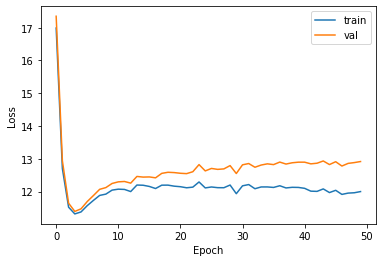

In [12]:
trainer.plot()

In [13]:
def print_prob(probs, labels):
    items = [x for x in sorted(zip(probs, genre_cols), reverse=True)]
    for (prob, genre), label in zip(items, labels):
        print('{:15s}{:>5.2f}% {}'.format(genre, prob*100, label))

In [14]:
num_show = 2
i_start = 0

y_train = model.predict(x_train)

for idx in range(i_start, num_show+i_start):
    print_prob(y_train[idx], t_train[idx])
    print()

Comedy         33.71% 0
Hentai         30.66% 0
School         14.24% 0
Romance        11.29% 1
Slice of Life   7.82% 0
Drama           3.47% 0
Fantasy         0.36% 0
Shoujo          0.25% 0
Shounen         0.20% 0
Ecchi           0.16% 0
Harem           0.12% 0
Seinen          0.11% 0
Supernatural    0.11% 0
Kids            0.08% 0
Action          0.04% 0
Magic           0.02% 0
Adventure       0.02% 0
Mystery         0.01% 0
Sports          0.01% 0
Horror          0.00% 0
Music           0.00% 0
Sci-Fi          0.00% 0
Historical      0.00% 0
Parody          0.00% 0
Psychological   0.00% 0
Shounen Ai      0.00% 0
Game            0.00% 0
Shoujo Ai       0.00% 0
Demons          0.00% 0
Super Power     0.00% 0
Martial Arts    0.00% 0
Thriller        0.00% 0
Dementia        0.00% 0
Josei           0.00% 0
Yuri            0.00% 1
Vampire         0.00% 0
Yaoi            0.00% 0
Police          0.00% 0
Cars            0.00% 0
Mecha           0.00% 0
Military        0.00% 0
Samurai         

In [15]:
weight = y_train.sum(axis=0) / len(y_train)
weight

array([2.30887450e-01, 1.89936730e-01, 1.50265855e-04, 2.77564593e-01,
       1.97138028e-04, 2.91791685e-03, 7.34048726e-02, 6.59880418e-03,
       1.24743638e-01, 9.39588293e-04, 2.43958806e-03, 1.19272402e-01,
       1.08002403e-02, 2.63438442e-03, 9.49018463e-05, 5.33310135e-02,
       1.75979245e-02, 1.10250629e-03, 6.22652655e-02, 1.86622239e-02,
       1.61937855e-03, 5.71337448e-03, 6.55110337e-04, 8.08053115e-04,
       1.31313188e-03, 5.85965551e-02, 3.25149957e-04, 6.06605794e-02,
       1.76566768e-01, 7.88137395e-03, 8.91747091e-03, 1.14802383e-04,
       6.10840340e-02, 1.29350282e-04, 3.80630066e-02, 1.31874043e-02,
       7.35554330e-03, 5.12281588e-03, 2.32972986e-02, 1.50881292e-04,
       1.44188779e-04, 3.62877085e-05, 3.36790258e-05])

In [16]:
def print_pred(probs, labels):
    items = [x for x in sorted(zip(probs-weight, genre_cols), reverse=True)]
    for (prob, genre), threshold, label in zip(items, weight, labels):
        pred = int(prob > 0)
        print('{:15s} pred:{} true:{}'.format(genre, pred, label))

In [17]:
num_show = 10
i_start = 0

y_test = model.predict(x_test)

for idx in range(i_start, num_show+i_start):
    print_pred(y_test[idx], t_test[idx])
    print()

    # mal_id = id_test[idx]
    
    # predict = y_test[idx]>=weight
    # actual  = t_test[idx]==1

    # for i in range(len(predict)):
    #     print(predict[i], actual[i])

    # TP = (actual & predict).sum()
    # FP = (~actual & predict).sum()
    # FN = (actual & ~predict).sum()
    # TN = (~actual & ~predict).sum()
    
    # print('{:^4} {:^4} {:^4} {:^4}'.format('T>T', 'F>T', 'T>F', 'F>F'))
    # print('{:^4} {:^4} {:^4} {:^4}\n'.format(TP, FP, FN, TN))

Sci-Fi          pred:1 true:0
Action          pred:1 true:0
Mecha           pred:1 true:0
Adventure       pred:1 true:1
Military        pred:1 true:0
Space           pred:1 true:0
Shounen         pred:1 true:0
Police          pred:1 true:0
Super Power     pred:0 true:0
Yuri            pred:0 true:0
Yaoi            pred:0 true:0
Josei           pred:0 true:0
Shoujo Ai       pred:0 true:0
Shounen Ai      pred:0 true:0
Vampire         pred:0 true:0
Cars            pred:0 true:0
Thriller        pred:0 true:0
Dementia        pred:0 true:0
Samurai         pred:0 true:0
Game            pred:0 true:1
Parody          pred:0 true:0
Martial Arts    pred:0 true:0
Psychological   pred:0 true:0
Music           pred:0 true:0
Harem           pred:0 true:0
Horror          pred:0 true:0
Demons          pred:0 true:0
Mystery         pred:0 true:0
Seinen          pred:0 true:1
Ecchi           pred:0 true:0
Sports          pred:0 true:0
Historical      pred:0 true:0
Shoujo          pred:0 true:1
Magic     